In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sparselandtools.dictionaries import Dictionary
from sklearn.linear_model import Lasso
from mpl_toolkits.axes_grid1 import ImageGrid
from sparselandtools.learning import ApproximateKSVD, KSVD
from sparselandtools.pursuits import OrthogonalMatchingPursuit, Pursuit, LassoP

In [108]:
class Lasso_Pursuit(Pursuit):
	def fit(self, Y):
		clf = Lasso(alpha=1)
		return clf.fit(self.D, Y).coef_

# Langevin wrapper for KSVD library
class lang(Pursuit):
	def fit(self, y):
		sigma=self.tol
		X = self.D
		
		# def omega_bar(t):
		# 	return t ** 2 * (t <= 1) + (2 * np.abs(t) - 1) * (t > 1)

		norm = np.linalg.norm(X, ord='fro')
		beta = 4 * sigma * sigma
		tau = 4 * sigma / norm
		T = X.shape[0]
		h = beta / norm ** 2

		if len(y.shape) == 2:
			L = np.zeros((X.shape[1], y.shape[1]))
		else:
			L = np.zeros(X.shape[1])
		lambd = np.zeros_like(L)
		H = 0
		errs = []

		XX = X.T @ X
		Xy = X.T @ y
		i = 0
		while H < T:
			nablaV = (2 / beta) * (Xy - XX @ L)
			nablaV = nablaV - 4 * L / (tau ** 2 + L ** 2)
			L = L + h * nablaV + np.sqrt(2 * h) * np.random.normal(0, 1, L.shape)
			H = H + 1
			lambd = lambd + h * L / T
		return lambd

class lang2(Pursuit):

	def fit(self, y):
		D = self.D
		alpha=self.tol
		DD = D.T @ D 
		DY = D.T @ Y
		if len(Y.shape) > 1:
			u = np.random.normal(0, 1, (D.shape[1], Y.shape[1]))
		else:
			u = np.random.normal(0, 1, D.shape[1])
		# s = f(np.abs(u), u0)
		s = u
		for i in range(100):
			T = (DY - DD @ s)
			grad = T - lambd * np.sign(s) + np.sqrt(2) * np.random.normal(0, 1, s.shape)
			# u0 = u0 - alpha * T 
			# u = u - alpha * grad
			# s = f(np.abs(u), u0)
			s = s + alpha * grad
		return s


Functions

In [109]:
def f(u, u0):
	return (u >= u0) * (u - u0)

def heav(u):
	return (u>=0) * 1

def lsc(Y, D, u0, lambd, alpha=1e-3, tol=1e-3):
	DD = D.T @ D 
	DY = D.T @ Y
	u = np.random.normal(0, 1, (D.shape[1], Y.shape[1]))
	s = f(np.abs(u), u0)
	while True:
		grad = (DY - DD @ s) * (s > 0) - lambd * np.sign(u) + np.sqrt(2) * np.random.normal(0, 1, s.shape)
		u_new = u - alpha * grad
		s = f(np.abs(u_new), u0)
		print(s)
		if np.linalg.norm(u - u_new) < tol:
			break
		u = u_new
	return s



$$
\begin{align*}
	Y \in \mathbb{R}^{d \times n}, & D \in \mathbb{R}^{d \times k}, X \in \mathbb{R}^{k \times n} \\
	Y &= DX \\
	[y_1 \cdots y_n] &= [d_1 \cdots d_k] [x_1 \cdots x_n]
\end{align*}
$$

In [110]:
# Dictionary contains bar with patch_shape dimesnions
patch_shape = (8,8)

# dimensions and number of atoms
d = np.prod(patch_shape)
k = np.sum(patch_shape)
n = 2000
shape_Y = (d, n)
shape_D = (d, k)
shape_X = (k, n)

# noise term for synthetic data
sigma_data = 0.001

# Sparsity constants for synthetic data
lambd = 1
pi = 0.2
u0 = -np.log(pi) / lambd
nsparse = 3

Generate synthetic data through bars dictionary

<StemContainer object of 3 artists>

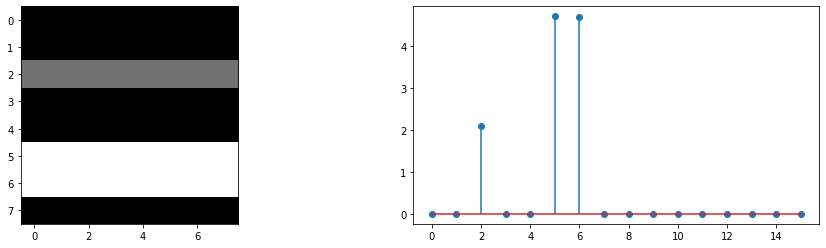

In [111]:
patches = []
# Horizontal bars
h_bar = np.ones(patch_shape[1])
for r in range(patch_shape[0]):
	patch = np.zeros(patch_shape)
	patch[r,:] = h_bar
	patches.append(patch)
# Vertical bars
v_bar = np.ones(patch_shape[0])
for c in range(patch_shape[1]):
	patch = np.zeros(patch_shape)
	patch[:,c] = v_bar
	patches.append(patch)
patches = np.array(patches)

# True dictionary
D_true = patches.reshape((-1, d)).T

# True sparse coefficients X
# U = np.random.exponential(lambd, size=shape_X)
# X_true = f(U, u0)
X_true = np.zeros(shape_X)
for c in range(shape_X[1]):
	X_true[np.random.choice(shape_X[0], nsparse, replace=False),c] = np.random.uniform(-5, 5, nsparse)


# Synthetic Data generation
Y = D_true @ X_true + np.random.normal(0, sigma_data, size=shape_Y)
Y = Y / np.linalg.norm(Y, axis=0)

plt.figure(figsize=(16,4))
plt.subplot(121)
plt.imshow(Y[:,1].reshape(patch_shape), cmap='gray')
plt.subplot(122)
plt.stem(X_true[:,1])

In [105]:
# X_true = lsc(Y, D_true, u0, lambd)

In [126]:
shape_D_new = (shape_D[0], shape_D[1] + 20)
# shape_D_new = shape_D
D_est = np.random.normal(-1, 1, shape_D_new)
D_est = D_est / np.linalg.norm(D_est, axis=0)
X_est = np.zeros((shape_D[1], shape_Y[1]))

ksvd = ApproximateKSVD(
				dictionary=Dictionary(D_est), 
				pursuit=lang, 
				sparsity=None,
				noise_gain=1e-1, 
				sigma=1)

ksvd.fit(Y, iter=250)
D_est = ksvd.dictionary.matrix
print('please')

INFO:root:Start iteration 1
INFO:root:Entering sparse coding stage...
INFO:root:Sparse coding stage ended.
INFO:root:Start iteration 2
INFO:root:Entering sparse coding stage...
INFO:root:Sparse coding stage ended.
INFO:root:Start iteration 3
INFO:root:Entering sparse coding stage...
INFO:root:Sparse coding stage ended.
INFO:root:Start iteration 4
INFO:root:Entering sparse coding stage...
INFO:root:Sparse coding stage ended.
INFO:root:Start iteration 5
INFO:root:Entering sparse coding stage...
INFO:root:Sparse coding stage ended.
INFO:root:Start iteration 6
INFO:root:Entering sparse coding stage...
INFO:root:Sparse coding stage ended.
INFO:root:Start iteration 7
INFO:root:Entering sparse coding stage...
INFO:root:Sparse coding stage ended.
INFO:root:Start iteration 8
INFO:root:Entering sparse coding stage...
INFO:root:Sparse coding stage ended.
INFO:root:Start iteration 9
INFO:root:Entering sparse coding stage...
INFO:root:Sparse coding stage ended.
INFO:root:Start iteration 10
INFO:roo

please


[ 1  0  4  3  2  6  7  5 10 11 12  8  9 14 13 15 21 26 17 20 23 30 31 35
 34 24 28 33 16 22 32 19 27 18 25 29]


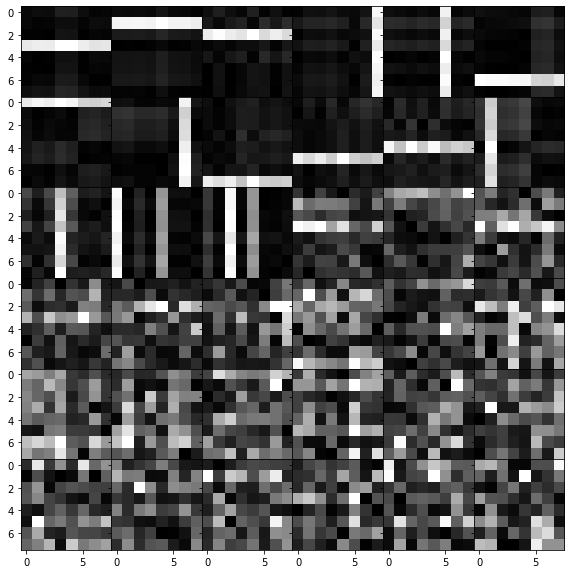

In [128]:
# plt.stem(ksvd.alphas[:,6])
D_var = np.max(np.abs(D_true.T @ D_est), axis=0)
inds = np.argsort(D_var)[::-1]
best_100 = np.abs(D_est[:, inds[:100]])
fig = plt.figure(figsize=(10, 10))
gsize = int(np.ceil(np.sqrt(shape_D_new[1])))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(gsize, gsize),  # creates 2x2 grid of axes
                 axes_pad=0,  # pad between axes in inch.
                 )

for ax, im in zip(grid, best_100.T):
    # Iterating over the grid returns the Axes.
    ax.imshow(im.reshape(patch_shape), cmap='gray')

plt.show()